In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os, sys
import folium
import datetime as dt

%matplotlib inline
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

plt.style.use('ggplot')
color_pal = ["#F8766D", "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"]

import warnings
warnings.filterwarnings(action='ignore')

from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.cluster import KMeans, DBSCAN
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

import folium

In [2]:
raw_df = pd.read_csv('new_jan_1.csv')

In [3]:
raw_df.head()

,taxi_id,trip_seconds,fare,tips,tolls,extras,trip_total,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,trip_minuate,trip_km
0,85.0,180.0,4.50,0.0,0.0,0.0,4.50,199.0,510.0,199.0,510.0,3.0,0.643700
1,4237.0,480.0,7.00,0.0,0.0,0.0,7.00,686.0,500.0,686.0,500.0,8.0,1.770300
2,1987.0,1080.0,17.75,0.0,0.0,0.0,17.75,599.0,346.0,660.0,120.0,18.0,9.977900
3,6400.0,60.0,3.75,0.0,0.0,0.0,3.75,527.0,24.0,527.0,24.0,1.0,0.321900
4,7418.0,180.0,5.00,2.0,0.0,1.5,8.50,210.0,470.0,744.0,605.0,3.0,1.001646


In [4]:
df = raw_df

In [5]:
# 주행거리가 0인 데이터를 랜덤포레스트를 통해 채워넣은 데이터
df[df['trip_km']==0].__len__()

0

In [6]:
# 주행요금이 0인 데이터 삭제
df = df.loc[df['trip_total']!=0, :]

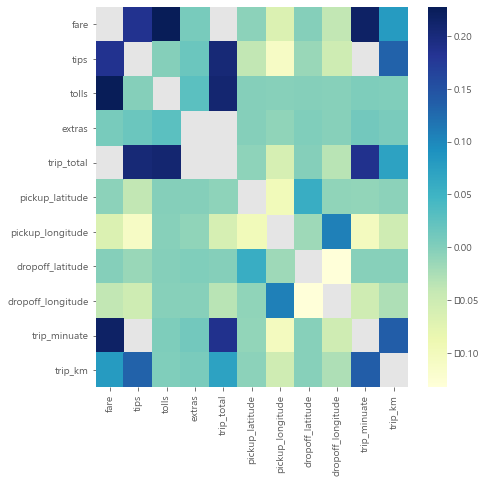

In [7]:
plt.figure(figsize=(7,7))
mask=df.iloc[:,2:].corr() > 0.3
sns.heatmap(df.iloc[:,2:].corr(),cmap='YlGnBu',mask=mask,fmt='.1g')

In [8]:
# 결측치 확인
df.isnull().sum()

taxi_id              0
trip_seconds         0
fare                 0
tips                 0
tolls                0
extras               0
trip_total           0
pickup_latitude      0
pickup_longitude     0
dropoff_latitude     0
dropoff_longitude    0
trip_minuate         0
trip_km              0
dtype: int64

(-25.0, 500.0)

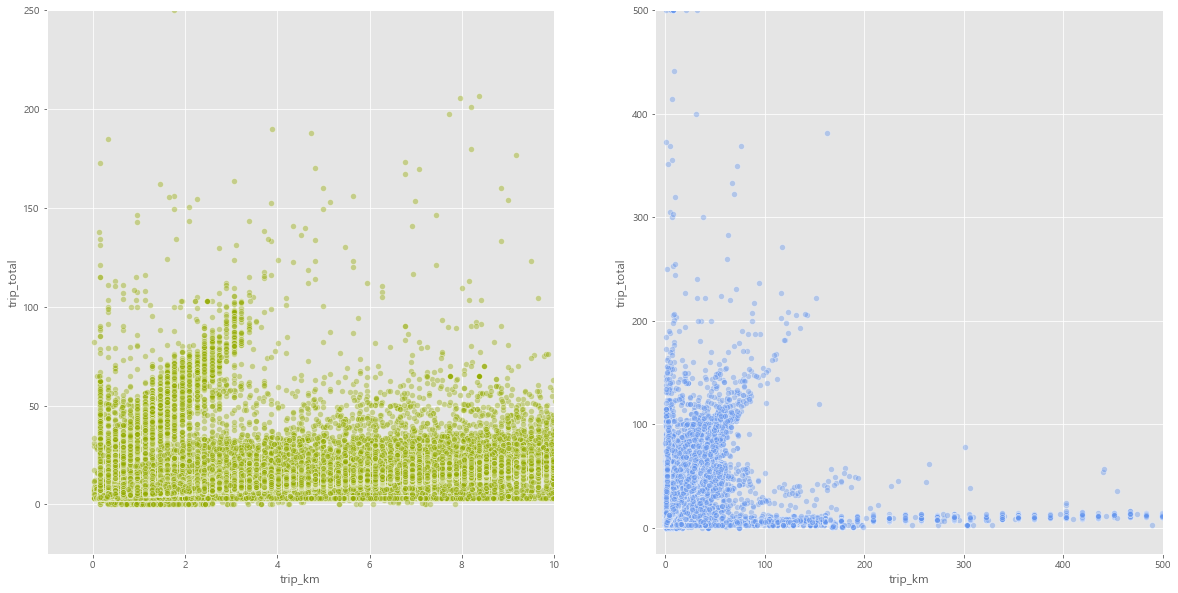

In [9]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
sns.scatterplot(data=df, x='trip_km', y='trip_total', ax=ax[0], color=color_pal[2] ,alpha=0.4)
ax[0].set_xlim(-1,10)
ax[0].set_ylim(-25,250)

sns.scatterplot(data=df, x='trip_km', y='trip_total', ax=ax[1], color='cornflowerblue', alpha=0.4)
ax[1].set_xlim(-10,500)
ax[1].set_ylim(-25,500)

#### 표준화 및 역할 정의

In [10]:
X_list = list(df.columns)
X_list.remove('trip_total')

# 데이터 표준화
scaler = StandardScaler()
# 목표변수 y를 trip_total로 설정

df_raw_x = scaler.fit_transform(df[X_list])
df_raw_y = scaler.fit_transform(df[['trip_total']])

## k-평균 군집분석

#### 군집 개수 찾기 : 각 데이터로부터 가장 가까운 군집 중심점까지의 거리 제곱합


In [11]:
# 최대 군집 생성 개수
n_iter_cluster = 5
cluster_range = [i+1 for i in range(n_iter_cluster)]
clus_error = []
for v_n_clus in cluster_range : 
    clus = KMeans(v_n_clus)
    clus.fit(df_raw_x)
    # 각 데이터로 부터 가장 가까운 군집 중심점까지 거리 제곱합
    clus_error.append(clus.inertia_)
ds_error = pd.DataFrame({'NumberofCluster' : cluster_range,
                        'Error' : clus_error})
ds_error

,NumberofCluster,Error
0,1,1.660235e+07
1,2,1.491638e+07
2,3,1.384306e+07
3,4,1.262463e+07
4,5,1.159969e+07


#### 4-2) 군집별 군집 중시점까지 거리 제곱합 시각화

Text(0, 0.5, 'Sum of squared distance')

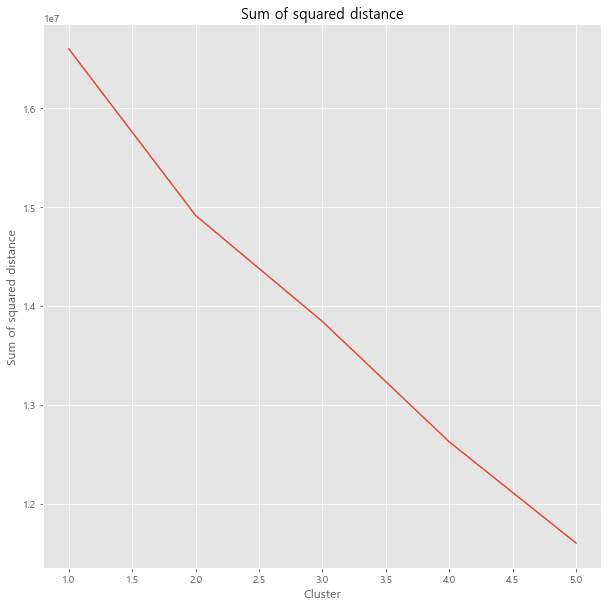

In [12]:
plt.figure(figsize = (10,10))
plt.plot(ds_error['NumberofCluster'], ds_error['Error'])
plt.title("Sum of squared distance")
plt.xlabel('Cluster')
plt.ylabel('Sum of squared distance')

#### 4-3) k-평균 군집 번호 생성

In [13]:
clus = KMeans(5)
clus.fit(df_raw_x)
cluster_kmeans = [i+1 for i in clus.labels_]
df['ClusterKmeans'] = cluster_kmeans
df.head()

,taxi_id,trip_seconds,fare,tips,tolls,extras,trip_total,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,trip_minuate,trip_km,ClusterKmeans
0,85.0,180.0,4.50,0.0,0.0,0.0,4.50,199.0,510.0,199.0,510.0,3.0,0.643700,1
1,4237.0,480.0,7.00,0.0,0.0,0.0,7.00,686.0,500.0,686.0,500.0,8.0,1.770300,4
2,1987.0,1080.0,17.75,0.0,0.0,0.0,17.75,599.0,346.0,660.0,120.0,18.0,9.977900,4
3,6400.0,60.0,3.75,0.0,0.0,0.0,3.75,527.0,24.0,527.0,24.0,1.0,0.321900,4
4,7418.0,180.0,5.00,2.0,0.0,1.5,8.50,210.0,470.0,744.0,605.0,3.0,1.001646,4


#### 4-4) k-평균 군집별 데이터 요약

In [14]:
ds_summary_km = df.groupby("ClusterKmeans").agg(['min','mean','max'])
level0 = ds_summary_km.columns.get_level_values(0)
level1 = ds_summary_km.columns.get_level_values(1)
ds_summary_km.columns = level0 + '_' + level1
ds_summary_km.reset_index(inplace = True)
ds_summary_km.round(3)

,ClusterKmeans,taxi_id_min,taxi_id_mean,taxi_id_max,trip_seconds_min,trip_seconds_mean,trip_seconds_max,fare_min,fare_mean,fare_max,...,dropoff_latitude_max,dropoff_longitude_min,dropoff_longitude_mean,dropoff_longitude_max,trip_minuate_min,trip_minuate_mean,trip_minuate_max,trip_km_min,trip_km_mean,trip_km_max
0,1,0.0,4369.295,8762.0,0.0,532.827,2640.0,0.00,8.910,355.00,...,640.0,2.0,504.473,785.0,0.0,8.880,44.0,0.016,3.187,522.941
1,2,2213.0,2213.000,2213.0,2520.0,2520.000,2520.0,999.99,999.990,999.99,...,225.0,6.0,6.000,6.0,42.0,42.000,42.0,42.232,42.232,42.232
2,3,170.0,4291.387,8144.0,0.0,410.323,1440.0,3.25,8.784,33.75,...,754.0,6.0,391.258,774.0,0.0,6.839,24.0,0.322,5.264,18.025
3,4,0.0,4374.172,8760.0,0.0,567.133,2640.0,0.00,9.933,300.00,...,784.0,1.0,385.410,785.0,0.0,9.452,44.0,0.016,3.754,533.074
4,5,0.0,4394.945,8760.0,0.0,2109.493,86340.0,0.00,40.893,9002.29,...,784.0,1.0,388.209,785.0,0.0,35.158,1439.0,0.016,25.535,4828.032


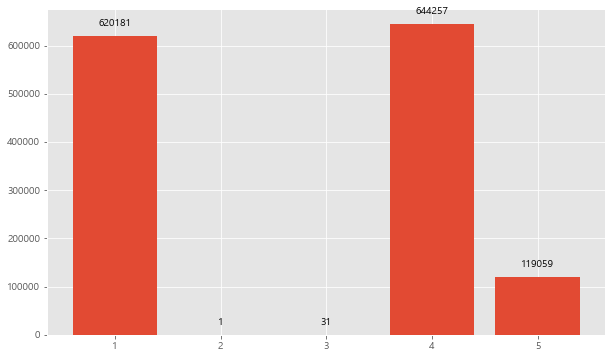

In [15]:
tmp = df.groupby('ClusterKmeans')[['trip_total']].count().rename(columns={'trip_total':'counts'})
plt.figure(figsize=(10,6))
plt.bar(tmp.index, tmp.counts)

for x, y in zip(tmp.index, tmp.counts):
    label = "{0}".format(y)
    plt.annotate(label, (x,y), textcoords='offset pixels', 
                 xytext=(0,10), 
                 ha='center')

## 군집 1, 2, 3에 대한 군집 특성 확인

In [16]:
df1 = df[df['ClusterKmeans']==1]
df2 = df[df['ClusterKmeans']==4]
df3 = df[df['ClusterKmeans']==5]

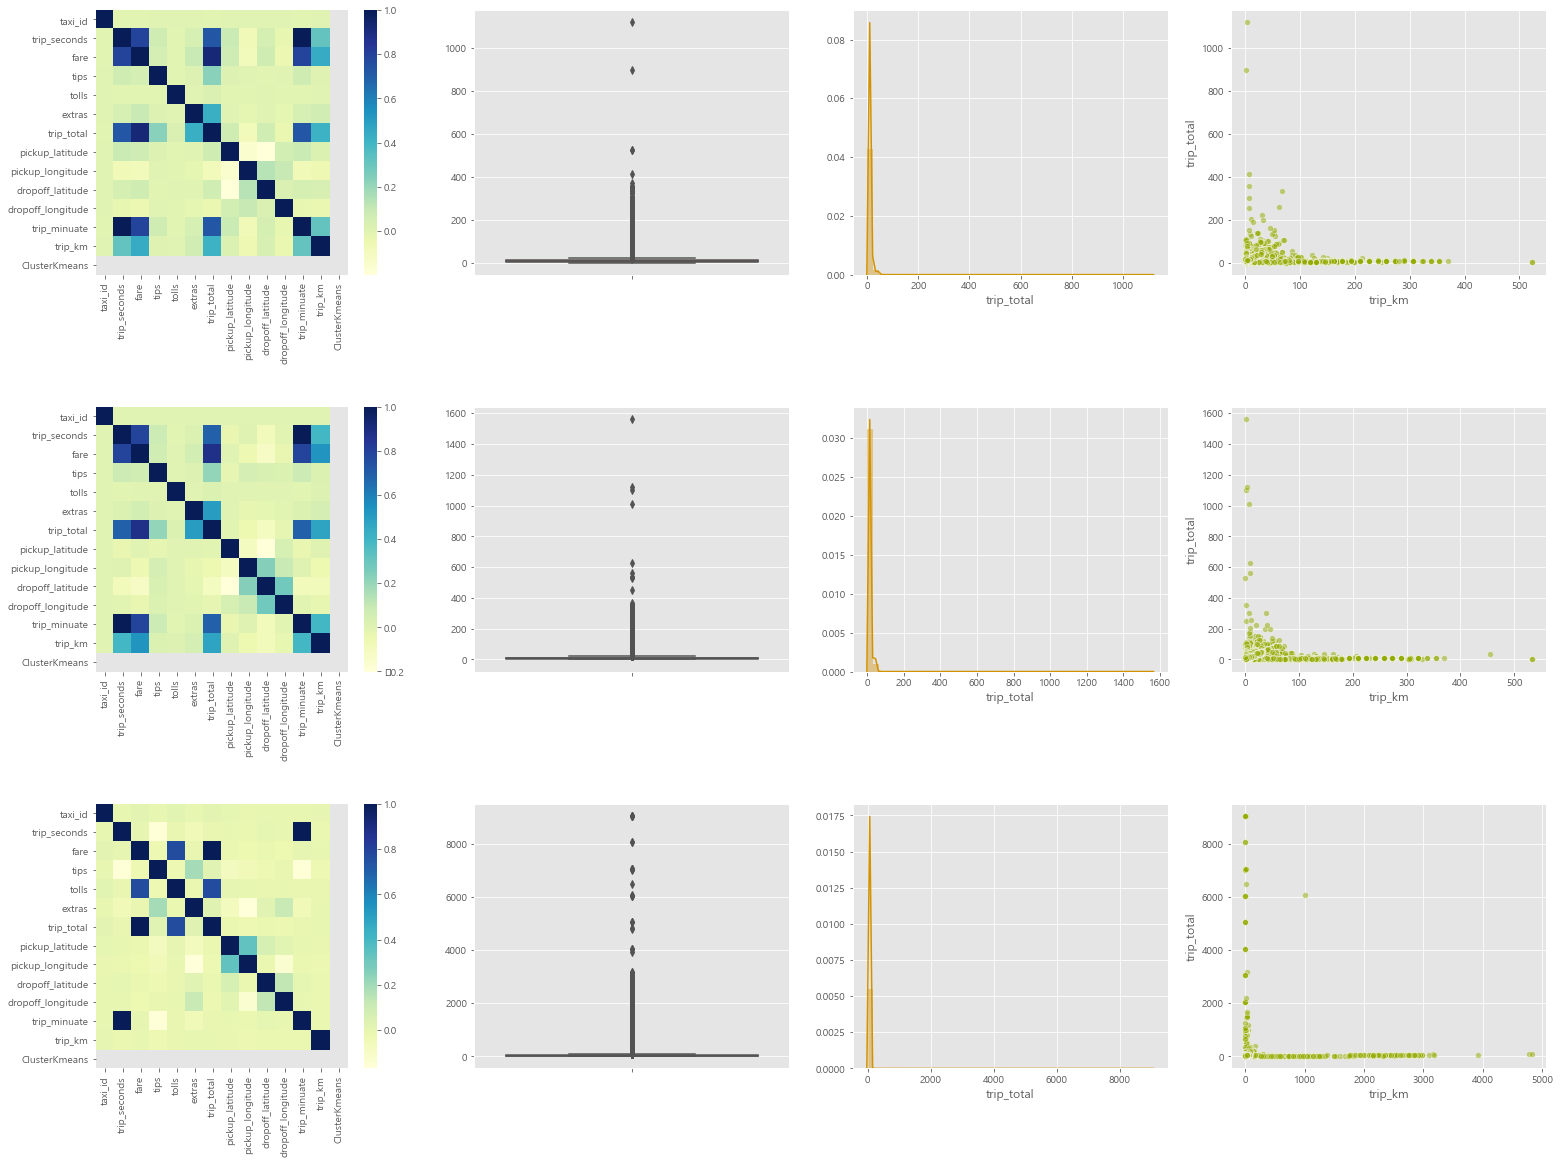

In [25]:
fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(26,15))
data = [df1, df2, df3]
for idx, d in enumerate(data):

    sns.heatmap(d.corr(),cmap='YlGnBu',fmt='.1g', ax=ax[idx,0])
    sns.boxplot(d[['trip_total', 'trip_km', 'trip_minuate']], orient='v', ax=ax[idx,1])
    sns.distplot(d.trip_total, ax=ax[idx,2], color=color_pal[1])
    sns.scatterplot(data=d, y='trip_total', x='trip_km', ax=ax[idx,3], alpha=0.5, color=color_pal[2])
    
plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.5, wspace=0.2)

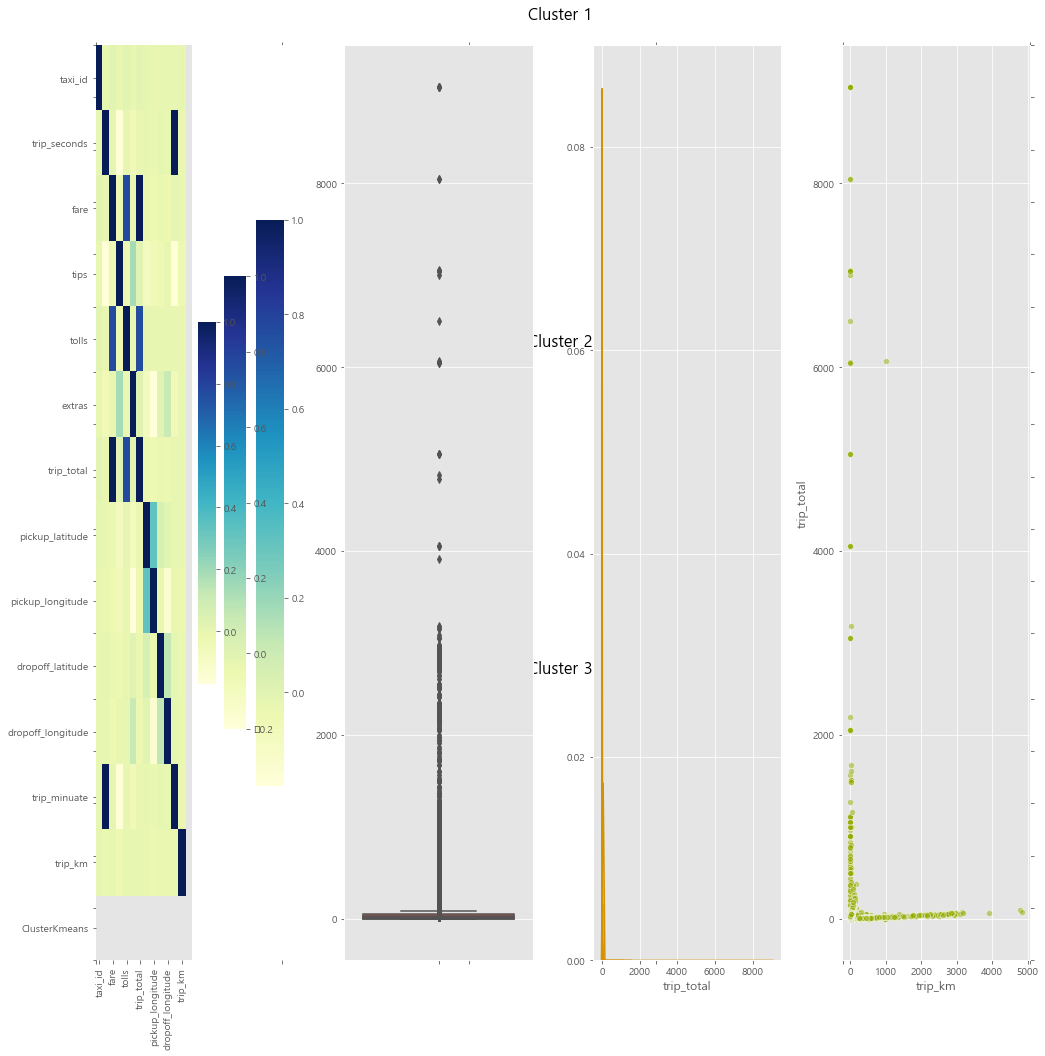

In [38]:
fig, big_axes = plt.subplots( figsize=(15.0, 15.0) , nrows=3, ncols=1, sharey=True) 

for row, big_ax in enumerate(big_axes, start=1):
    big_ax.set_title("Cluster %s \n" % row, fontsize=16)

    # Turn off axis lines and ticks of the big subplot 
    # obs alpha is 0 in RGBA string!
    big_ax.tick_params(labelcolor=(1.,1.,1., 0.0), top='off', bottom='off', left='off', right='off')
    # removes the white frame
    big_ax._frameon = False

data = [df1, df2, df3]


for d in data:
    for i in range(1,5):
        ax = fig.add_subplot(3,4,i)
        if i in [1,5,9]:
            sns.heatmap(d.corr(),cmap='YlGnBu',fmt='.1g')
        elif i in [2,6,10]:
            sns.boxplot(d[['trip_total', 'trip_km', 'trip_minuate']], orient='v')
        elif i in [3,7,11]:
            sns.distplot(d.trip_total, color=color_pal[1])
        elif i in [4,8,12]:  
            sns.scatterplot(data=d, y='trip_total', x='trip_km', alpha=0.5, color=color_pal[2])
    

fig.set_facecolor('w')
plt.tight_layout()
plt.show()